In [93]:
import pandas as pd
import numpy as np

In [94]:
dataset = pd.read_excel('Rain_Water_Data.xlsx', sep=';', header=0, error_bad_lines=False)

# summarize
print(dataset.shape)
print(dataset.head())

(59828, 8)
      ID               TIMESTAMP  TRENDFLAGS  STATUS  VALUE TRENDFLAGS_TAG  \
0  95841 2019-04-27 11:00:00.587           0       0   1840            { }   
1  95840 2019-04-27 10:45:00.090           0       0   1829            { }   
2  95839 2019-04-27 10:30:00.113           0       0   1819            { }   
3  95838 2019-04-27 10:15:00.100           0       0   1813            { }   
4  95837 2019-04-27 10:00:00.143           0       0   1813            { }   

  STATUS_TAG  ACTUALVALUE  
0       {ok}          NaN  
1       {ok}     235300.0  
2       {ok}     234300.0  
3       {ok}     233700.0  
4       {ok}     233700.0  


In [95]:
from pandas import datetime


df = pd.DataFrame(dataset,columns=['TIMESTAMP', 'ACTUALVALUE'])
#df.head(10)

#converting dataframe index to datetime index
df['TimeReviewed'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TimeReviewed')
df.drop(['TIMESTAMP'], axis=1, inplace=True)
df.head()



,ACTUALVALUE
TimeReviewed,
2019-04-27 11:00:00.587,NaN
2019-04-27 10:45:00.090,235300.0
2019-04-27 10:30:00.113,234300.0
2019-04-27 10:15:00.100,233700.0
2019-04-27 10:00:00.143,233700.0


In [96]:
df2 = df.resample('D').sum()
df2.head()

,ACTUALVALUE
TimeReviewed,
2017-08-05,1502800.0
2017-08-06,5548800.0
2017-08-07,5548800.0
2017-08-08,5606600.0
2017-08-09,5548800.0


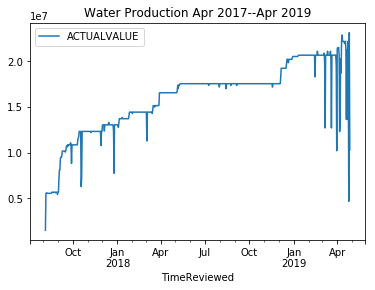

In [97]:
import matplotlib.pyplot as plt
df2.plot()
plt.title('Water Production Apr 2017--Apr 2019')
plt.show()

In [98]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [99]:
# convert the integer values to floating point values, which are more suitable for modeling with a neural network.
dataset = df2.values
dataset = dataset.astype('float32')

In [100]:
# Since LSTMs are sensitive to the scale of input data(specifically when sigmoid and tanh activation functions is used). We need to normalize data in order to rescale to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [101]:
# split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


422 209


In [102]:
#the function has two arguments: dataset,look_back, which is the number of previous time steps to use as input variables to predict the next time period by default = 1
#This default will create a dataset where X is the actual value of water consumed at a given time (t) and Y is the actual value of water consumed at the next time (t + 1).


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [103]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [104]:
# reshape input to be [samples, time steps, features] in order for it to fit in the LSTM
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [108]:
# create and fit the LSTM network
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction.
# The network is trained for 100 epochs and a batch size of 1 is used.
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY,  validation_split=0.4, epochs=10)                                       

Train on 252 samples, validate on 168 samples
Epoch 1/10
252/252 [==============================] - 3s 10ms/step - loss: 0.2353 - val_loss: 0.4668
Epoch 2/10
252/252 [==============================] - 0s 164us/step - loss: 0.2165 - val_loss: 0.4358
Epoch 3/10
252/252 [==============================] - 0s 169us/step - loss: 0.1985 - val_loss: 0.4063
Epoch 4/10
252/252 [==============================] - 0s 329us/step - loss: 0.1817 - val_loss: 0.3780
Epoch 5/10
252/252 [==============================] - 0s 176us/step - loss: 0.1657 - val_loss: 0.3512
Epoch 6/10
252/252 [==============================] - 0s 286us/step - loss: 0.1508 - val_loss: 0.3257
Epoch 7/10
252/252 [==============================] - 0s 211us/step - loss: 0.1366 - val_loss: 0.3016
Epoch 8/10
252/252 [==============================] - 0s 207us/step - loss: 0.1237 - val_loss: 0.2784
Epoch 9/10
252/252 [==============================] - 0s 135us/step - loss: 0.1114 - val_loss: 0.2565
Epoch 10/10
252/252 [================

In [109]:
score = model.evaluate(testX, testY,
                       batch_size=100, verbose=1)


print('Test accuracy:', score)
print('Accuracy:',score*100)
 

207/207 [==============================] - 0s 33us/step
Test accuracy: 0.32310757271333596
Accuracy: 32.31075727133359


In [110]:
#we can estimate the performance of the model on the train and test datasets.
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original datas
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [111]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 8394592.71 RMSE
Test Score: 12297033.44 RMSE


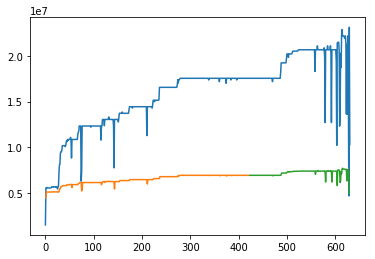

In [112]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# original dataset in blue, the predictions for the training dataset in orange, and the predictions on the unseen test dataset in green.